In [63]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from pandas.tseries.offsets import BDay
import time
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

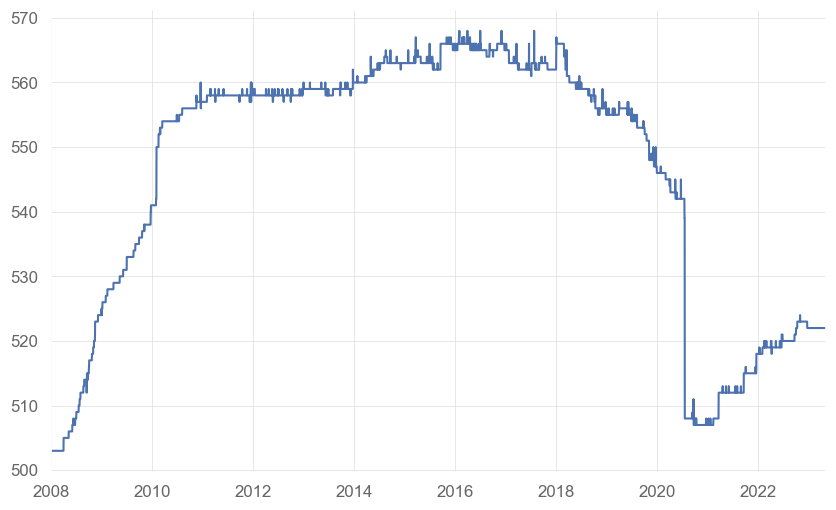

In [2]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')
earnings = pd.read_parquet('data/US/earnings.pq')
cash_flow = pd.read_parquet('data/US/cash_flow.pq')

In [3]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]

earnings

,,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,Ticker,,,,,,,,
2000-02-17,A,2000-02-17,2000-01-31,None,USD,0.30,0.22,0.08,36.3636
2000-05-16,A,2000-05-16,2000-04-30,None,USD,0.35,0.32,0.03,9.3750
2000-08-17,A,2000-08-17,2000-07-31,None,USD,0.39,0.20,0.19,95.0000
2000-11-20,A,2000-11-20,2000-10-31,None,USD,0.73,0.54,0.19,35.1852
2001-02-20,A,2001-02-20,2001-01-31,None,USD,0.51,0.45,0.06,13.3333
...,...,...,...,...,...,...,...,...,...
2022-02-15,ZTS,2022-02-15,2021-12-31,BeforeMarket,USD,1.00,0.96,0.04,4.1667
2022-05-05,ZTS,2022-05-05,2022-03-31,BeforeMarket,USD,1.32,1.23,0.09,7.3171
2022-08-04,ZTS,2022-08-04,2022-06-30,BeforeMarket,USD,1.20,1.22,-0.02,-1.6393


In [4]:
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
balance_sheet['Date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet = balance_sheet.droplevel(0).set_index('Date',append=True)
balance_sheet = balance_sheet.reorder_levels(['Date','Ticker'])
balance_sheet = balance_sheet[~balance_sheet.index.duplicated(keep='first')]

balance_sheet

,,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,...,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,propertyPlantAndEquipmentNet,accumulatedDepreciation,netWorkingCapital,netInvestedCapital,commonStockSharesOutstanding
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,462500000.00
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,461764706.00
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,450000000.00
1999-10-31,A,1999-10-31,1999-10-31,USD,5444000000.00,None,None,404000000.00,2062000000.00,3382000000.00,None,...,None,None,5444000000.00,None,1387000000.00,1387000000.00,None,None,None,440000000.00
2000-03-15,A,2000-01-31,2000-03-15,USD,7107000000.00,None,None,560000000.00,2621000000.00,4486000000.00,None,...,None,None,7107000000.00,1410000000.00,1408000000.00,1408000000.00,None,None,None,440000000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,ZTS,2021-12-31,2022-02-15,USD,13900000000.00,1474000000.00,None,392000000.00,9356000000.00,4543000000.00,320000000.00,...,None,1068000000.00,13899000000.00,3482000000.00,None,2603000000.00,None,5133000000.00,11135000000.00,475600000.00
2022-05-05,ZTS,2022-03-31,2022-05-05,USD,13860000000.00,1430000000.00,None,423000000.00,9202000000.00,4658000000.00,287000000.00,...,None,1046000000.00,13860000000.00,3135000000.00,None,2676000000.00,None,3803000000.00,11236000000.00,474100000.00
2022-08-04,ZTS,2022-06-30,2022-08-04,USD,13770000000.00,1390000000.00,None,507000000.00,9190000000.00,4580000000.00,274000000.00,...,None,1059000000.00,13770000000.00,2648000000.00,None,2752000000.00,None,3600000000.00,11153000000.00,471500000.00


In [5]:
cash_flow = pd.read_parquet('data/US/cash_flow.pq')
cash_flow['Date'] = pd.to_datetime(cash_flow['filing_date'])
cash_flow = cash_flow.droplevel(0).set_index('Date',append=True)
cash_flow = cash_flow.reorder_levels(['Date','Ticker'])
cash_flow = cash_flow[~cash_flow.index.duplicated(keep='first')]
cash_flow

,,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,netIncome,...,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,changeInWorkingCapital,stockBasedCompensation,otherNonCashItems,freeCashFlow
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
2000-03-15,A,2000-01-31,2000-03-15,USD,None,None,None,None,1192000000.00,None,131000000.00,...,113000000.00,91000000,None,None,None,None,157000000.00,None,None,293000000.00
2000-06-12,A,2000-04-30,2000-06-12,USD,None,11000000.00,None,None,-11000000.00,None,166000000.00,...,192000000.00,131000000,None,None,None,None,-223000000.00,None,-84000000.00,-169000000.00
2000-09-01,A,2000-07-31,2000-09-01,USD,None,282000000.00,None,None,73000000.00,None,155000000.00,...,238000000.00,226000000,None,None,None,None,-268000000.00,None,-4000000.00,-157000000.00
2001-01-17,A,2000-10-31,2001-01-17,USD,None,356000000.00,None,None,21000000.00,None,305000000.00,...,None,376000000,None,None,None,None,123000000.00,None,-115000000.00,47000000.00
2001-03-19,A,2001-01-31,2001-03-19,USD,None,None,None,None,504000000.00,None,154000000.00,...,None,173000000,None,None,None,None,-510000000.00,None,9000000.00,-370000000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,ZTS,2021-12-31,2022-02-15,USD,25000000.00,156000000.00,-142000000.00,2000000.00,-314000000.00,87000000.00,414000000.00,...,86000000.00,168000000,-12000000.00,-14000000.00,None,223000000.00,62000000.00,14000000.00,31000000.00,511000000.00
2022-05-05,ZTS,2022-03-31,2022-05-05,USD,1000000.00,-136000000.00,-118000000.00,2000000.00,-545000000.00,-106000000.00,595000000.00,...,-15000000.00,115000000,-102000000.00,None,None,-354000000.00,-385000000.00,16000000.00,14000000.00,194000000.00
2022-08-04,ZTS,2022-06-30,2022-08-04,USD,32000000.00,-47000000.00,-203000000.00,2000000.00,-610000000.00,-105000000.00,529000000.00,...,16000000.00,146000000,-80000000.00,-33000000.00,None,-477000000.00,-326000000.00,15000000.00,32000000.00,190000000.00


In [6]:
income_statement = pd.read_parquet('data/US/income_statement.pq')
income_statement['Date'] = pd.to_datetime(income_statement['filing_date'])
income_statement = income_statement.droplevel(0).set_index('Date',append=True)
income_statement = income_statement.reorder_levels(['Date','Ticker'])
income_statement = income_statement[~income_statement.index.duplicated(keep='first')]
income_statement

,,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,sellingAndMarketingExpenses,...,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,74000000.00,None,None,...,None,None,1786000000.00,None,None,None,None,None,None,None
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,157000000.00,None,None,...,None,None,2010000000.00,None,None,None,None,None,None,None
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,135000000.00,None,None,...,None,None,2087000000.00,None,None,None,None,None,None,None
1999-10-31,A,1999-10-31,1999-10-31,USD,None,None,None,None,146000000.00,None,None,...,None,None,2448000000.00,None,None,None,None,None,None,None
2000-03-15,A,2000-01-31,2000-03-15,USD,290000000.00,0.00,202000000.00,0.00,131000000.00,625000000.00,None,...,0.00,71000000.00,2246000000.00,915000000.00,1160000000.00,31000000.00,0.00,0.00,88000000.00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,ZTS,2021-12-31,2022-02-15,USD,138000000.00,None,506000000.00,-1000000.00,414000000.00,593000000.00,None,...,None,93000000.00,1967000000.00,771000000.00,600000000.00,-90000000.00,None,413000000.00,414000000.00,None
2022-05-05,ZTS,2022-03-31,2022-05-05,USD,122000000.00,None,727000000.00,-1000000.00,595000000.00,465000000.00,None,...,None,133000000.00,1986000000.00,628000000.00,569000000.00,-62000000.00,None,594000000.00,595000000.00,None
2022-08-04,ZTS,2022-06-30,2022-08-04,USD,135000000.00,None,670000000.00,0.00,529000000.00,529000000.00,None,...,None,141000000.00,2052000000.00,701000000.00,625000000.00,-56000000.00,None,529000000.00,529000000.00,None


In [7]:
earnings['EarningsQuarter'] = pd.to_datetime(earnings['reportDate']).dt.to_period('Q')
earnings['IsReporting'] = 1

def DATES_EARNINGS(data:pd.DataFrame,start:float,end:float,_days_before:int,_days_after:int):

    all_earnings =data['EarningsQuarter'].dropna().unique().tolist()
    dates_earnings = pd.DataFrame(index = all_earnings,columns = ['start_pre','end_pre','start','end','start_post','end_post'])

    for earning in all_earnings:

        sample = data[data['EarningsQuarter']==earning][['IsReporting']]
        
        sample['IsReporting_%'] = sample['IsReporting'].div(sample['IsReporting'].sum())
        df = pd.DataFrame(sample.groupby(level=0)['IsReporting_%'].sum())
        tmp = (df['IsReporting_%']>start ) & (df['IsReporting_%']<end )

        try :
            dates_earnings.loc[earning,'start'] = df[tmp].index[0]
            dates_earnings.loc[earning,'end'] = df[tmp].index[-1]
            dates_earnings.loc[earning,'start_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1- _days_before)
            dates_earnings.loc[earning,'end_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1)
            dates_earnings.loc[earning,'start_post'] = dates_earnings.loc[earning,'end'] + BDay(1)
            dates_earnings.loc[earning,'end_post'] = dates_earnings.loc[earning,'end'] + BDay(1+_days_after)
            
        except :
            ''
    return dates_earnings.sort_index()

dates_earnings = DATES_EARNINGS(earnings,0.03,0.95,10,10).dropna()
dates_earnings

,start_pre,end_pre,start,end,start_post,end_post
1992Q2,1992-04-06 00:00:00,1992-04-20 00:00:00,1992-04-21 00:00:00,1992-06-30 00:00:00,1992-07-01 00:00:00,1992-07-15 00:00:00
1993Q1,1993-01-01 00:00:00,1993-01-15 00:00:00,1993-01-18 00:00:00,1993-03-31 00:00:00,1993-04-01 00:00:00,1993-04-15 00:00:00
1993Q2,1993-03-29 00:00:00,1993-04-12 00:00:00,1993-04-13 00:00:00,1993-06-30 00:00:00,1993-07-01 00:00:00,1993-07-15 00:00:00
1993Q3,1993-06-29 00:00:00,1993-07-13 00:00:00,1993-07-14 00:00:00,1993-09-30 00:00:00,1993-10-01 00:00:00,1993-10-15 00:00:00
1993Q4,1993-09-30 00:00:00,1993-10-14 00:00:00,1993-10-15 00:00:00,1993-12-31 00:00:00,1994-01-03 00:00:00,1994-01-17 00:00:00
...,...,...,...,...,...,...
2022Q3,2022-07-05 00:00:00,2022-07-19 00:00:00,2022-07-20 00:00:00,2022-08-04 00:00:00,2022-08-05 00:00:00,2022-08-19 00:00:00
2022Q4,2022-10-04 00:00:00,2022-10-18 00:00:00,2022-10-19 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,2022-11-23 00:00:00
2023Q1,2023-01-10 00:00:00,2023-01-24 00:00:00,2023-01-25 00:00:00,2023-02-28 00:00:00,2023-03-01 00:00:00,2023-03-15 00:00:00
2023Q2,2023-04-10 00:00:00,2023-04-24 00:00:00,2023-04-25 00:00:00,2023-05-31 00:00:00,2023-06-01 00:00:00,2023-06-15 00:00:00


In [8]:
def business_days(start_date,end_date):
    dates_list = pd.date_range(start=start_date,end=end_date,freq ='D')
    business_days_list = [date for date in dates_list if date.weekday()<5]
    return business_days_list

dates_earnings['dates_pre'] =   dates_earnings.apply(lambda x: business_days(x['start_pre'],x['end_pre']),axis=1)
dates_earnings['dates_earn'] =   dates_earnings.apply(lambda x: business_days(x['start'],x['end']),axis=1)
dates_earnings['dates_post'] =   dates_earnings.apply(lambda x: business_days(x['start_post'],x['end_post']),axis=1)
dates_earnings['dates_earn_cumul'] = dates_earnings['dates_earn'].cumsum()



In [182]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps = (eps_actual - eps_estimate).reindex_like(P).ffill()[P]

In [183]:
ebit = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalCurrentAssets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
roic = (ebit/(totalAssets - totalCurrentAssets)).reindex_like(P).ffill()[P]

In [184]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
book_value_share = book_value/ shares
close = market_data['close'].unstack().reindex_like(P).astype(float)
pb_ratio = (close/book_value_share).reindex_like(P).ffill()[P]

In [185]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)

operating_profit = income_statement['operatingIncome'].unstack().reindex_like(P).ffill().astype(float)
operating_margin = (operating_profit / total_revenue).reindex_like(P).ffill()[P]



In [186]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)
gross_margin = ((total_revenue - cost_revenue)/ total_revenue).stack()
gross_margin = gross_margin.unstack().reindex_like(P).ffill()[P]
gross_margin

Ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABK,ABMD,...,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.551253,0.02516,0.246815,NaN,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902
2023-04-03,0.551253,0.02516,0.246815,NaN,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902
2023-04-04,0.551253,NaN,0.246815,NaN,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902
2023-04-05,0.551253,NaN,0.246815,0.440632,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902


In [187]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).astype(float)
ltdebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stdebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
cash_equiv = balance_sheet['cashAndEquivalents'].unstack().reindex_like(P).ffill().astype(float)
EV = mkt_cap + (ltdebt+stdebt)  - cash_equiv.fillna(0)
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
EM = EV / ebitda

In [245]:
simulations_earnings = dates_earnings.loc['2017Q4':'2023Q1'].index
signal = pd.DataFrame().reindex_like(P)
for i,earning in enumerate(tqdm(simulations_earnings[1:-1])):
    i = i+1
    quarter = simulations_earnings[i]
    prev_quarter = simulations_earnings[i-1]
    start_train = market_data.head(1).index[0]
    dates_train = dates_earnings.loc[prev_quarter,'dates_earn_cumul']
    end_train = dates_earnings.loc[prev_quarter,'end']
    
    dates_signal = dates_earnings.loc[quarter,'dates_earn']
    tickers = R[R.index.isin(dates_signal)].dropna(1,'all').columns.tolist()
    for ticker in ['AAPL','MSFT','AMZN','GOOG','FB','NVDA','BRKB'] + random.sample(tickers,200):
        try :
            returns = R[P].sub(R[P].mean(1),0)[ticker]
            em_ticker, eps_ticker,gm_ticker,roic_ticker,pb_ratio_ticker,op_margin = EM[ticker].shift(),eps[ticker].shift(),gross_margin[ticker].shift(),roic[ticker].shift(),pb_ratio[ticker].shift(),operating_margin[ticker].shift()
            df = pd.DataFrame({'em':em_ticker,
                               'eps':eps_ticker,
                               'gm':gm_ticker,
                               'roic':roic_ticker,
                               'pb':pb_ratio_ticker,
                               'op_margin':op_margin,
                               'ret':returns})
        
            df_train = df[df.index.isin(dates_train)].dropna()
            df_train = df_train.rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
            df_test  = df[df.index.isin(dates_signal+ dates_train)].dropna()
            input_dates = df_test.index
            xdata = df_train[['em','eps','gm','roic','pb','op_margin']].values
            ydata = df_train['ret'].values
            neigh = SVR(kernel='rbf').fit(xdata,ydata)
            dates = []
            for date in dates_signal:
                try :
                    dates.append(date)
                    df_pred = df_test[df_test.index.isin(dates_train+ dates)].dropna().rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
                    x_test = df_pred[['em','eps','gm','roic','pb','op_margin']].loc[date].values.reshape(1,-1)
                    pred = neigh.predict(x_test)
                    signal.loc[date,ticker] = pred.ravel()
                except :
                    pass
        
        except :
            pass


100%|██████████| 20/20 [36:10<00:00, 108.52s/it]


Sharpe     -0.6
Turnover    0.0
biais      -1.6
dtype: float64

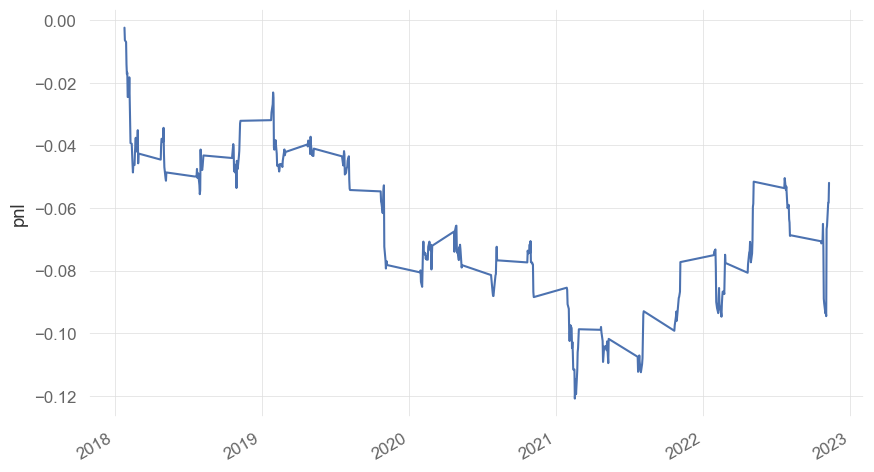

In [247]:
SIGNAL = signal.reindex_like(P)
SIGNAL = SIGNAL[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<1] = None
SIGNAL = SIGNAL[P].groupby(GICS['gicgrp'],axis=1).apply(center)
SIGNAL = SIGNAL[P].div(SIGNAL.abs().sum(1),0)
pnl = (SIGNAL[P].shift(1)*R).dropna(0,'all').sum(1)
sr = sharpe(pnl)
turnover = SIGNAL.fillna(0).diff().abs().sum(1).mean()

pnl.cumsum().plot()
plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)

In [ ]:
ta.cmo

In [138]:
net_debt = balance_sheet['netDebt'].unstack().reindex_like(P).ffill().astype(float)
cash = balance_sheet['cash'].unstack().reindex_like(P).ffill().astype(float)

debt_cash = (net_debt/ cash).stack()
debt_cash

            Ticker
2008-01-03  CAG       27.981265
2008-01-04  CAG       27.981265
            CTAS      15.751359
            DRI       69.924915
2008-01-07  CAG       27.981265
                        ...    
2023-04-06  YUM       31.291553
            ZBH       14.162364
            ZBRA      19.590476
            ZION      -0.041562
            ZTS        0.882156
Length: 2478545, dtype: float64

In [139]:
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
total_equity = balance_sheet['commonStockTotalEquity'].unstack().reindex_like(P).ffill().astype(float)
debt_equity = (total_debt/total_equity).stack()

In [140]:
net_income = income_statement['netIncome'].unstack().reindex_like(P).ffill().astype(float)
total_assets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
roa = (net_income/total_assets).stack()


In [141]:
roe =  (net_income/ total_equity).stack()

In [142]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)
gross_margin = ((total_revenue - cost_revenue)/ total_revenue).stack()


In [143]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)

operating_profit = income_statement['operatingIncome'].unstack().reindex_like(P).ffill().astype(float)
operating_margin = (operating_profit / total_revenue).stack()

In [144]:
current_assets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
current_liab = balance_sheet['totalCurrentLiabilities'].unstack().reindex_like(P).ffill().astype(float)
current_ratio = (current_assets/ current_liab).stack()

In [145]:
inventory = balance_sheet['inventory'].unstack().reindex_like(P).ffill().astype(float)
quick_ratio = ((current_assets - inventory)/ current_liab).stack()

In [146]:
asset_turnover_ratio = (total_assets/ total_revenue).stack()

In [147]:
price = market_data['close'].unstack().reindex_like(P).ffill().astype(float)
eps =  earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
pe_ratio = (price/eps).stack()

In [148]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).ffill().astype(float)
ps_ratio = (mkt_cap/total_revenue).stack()

In [149]:
earnings_yield = (eps/price).stack()

In [150]:
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
debt_to_ebitda = (total_debt/ebitda).stack()

In [151]:
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
ebitda_share = (ebitda/shares).stack()

In [152]:
ebit = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalCurrentAssets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
roic = (ebit/(totalAssets - totalCurrentAssets)).stack()


In [153]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
book_value_share = book_value/ shares
close = market_data['close'].unstack().reindex_like(P).astype(float)
pb_ratio = (close/book_value_share).stack()

In [154]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps_surprise = (eps_actual - eps_estimate).stack()

In [155]:
ratios = {
        'eps_surprise':eps_surprise,
        'pb_ratio':pb_ratio,
        'roic': roic,
        'ebitda_share':ebitda_share,
        'debt_to_ebitda': debt_to_ebitda,
        'earnings_yield': earnings_yield,
        'ps_ratio':ps_ratio,
        'pe_ratio':pe_ratio,
        'asset_turnover_ratio':asset_turnover_ratio,
        'quick_ratio':quick_ratio,
        'current_ratio':current_ratio,
        'operating_margin':operating_margin,
        'gross_margin':gross_margin,
        'roe':roe,
        'roa':roa,
        'debt_equity':debt_equity,
        'debt_cash':debt_cash

        }

In [156]:
result_df = pd.DataFrame()

# Iterate through the dictionary and add each DataFrame as a new column
for key, df in ratios.items():
    print(key)
    df = pd.DataFrame({key:df})
    df.index.names = ['Date','Ticker']

    # Unstack the MultiIndex to create columns for each level
    # Append the DataFrame to the result DataFrame
    ratios[key] = df

# Print the result DataFrame
print(result_df)

eps_surprise
pb_ratio
roic
ebitda_share
debt_to_ebitda
earnings_yield
ps_ratio
pe_ratio
asset_turnover_ratio
quick_ratio
current_ratio
operating_margin
gross_margin
roe
roa
debt_equity
debt_cash
Empty DataFrame
Columns: []
Index: []


In [157]:
data_raw = pd.DataFrame( {'close':market_data['close'].unstack().reindex_like(P).stack()})
features = list(ratios)
for col in tqdm(features):
    data_raw[col] = ratios[col]

data_raw

100%|██████████| 17/17 [00:09<00:00,  1.83it/s]


close  eps_surprise   pb_ratio      roic  ebitda_share  \
           Ticker                                                              
2008-01-01 ZMH     331.0000           NaN        NaN       NaN           NaN   
2008-01-02 A        36.2888           NaN        NaN       NaN           NaN   
           AA       36.1300           NaN        NaN       NaN           NaN   
           AAL      13.3200           NaN        NaN       NaN           NaN   
           AAP      37.5900           NaN        NaN       NaN           NaN   
...                     ...           ...        ...       ...           ...   
2023-04-05 YUM     131.9400          0.05  -4.266199  0.143026      2.111498   
           ZBH     128.5900          0.05   2.243135  0.011798      0.935653   
           ZBRA    300.1500          0.16   5.919800  0.043571      4.563802   
           ZION     28.6300          0.20   0.870831  0.006057      3.393156   
           ZTS     167.6500          0.10  17.910526  0.104327      1.645461   

                   debt_to_ebitda  earnings_yield   ps_ratio    pe_ratio  \
           Ticker                                                          
2008-01-01 ZMH                NaN             NaN        NaN         NaN   
2008-01-02 A                  NaN             NaN        NaN         NaN   
           AA                 NaN             NaN        NaN         NaN   
           AAL                NaN             NaN        NaN         NaN   
           AAP                NaN             NaN        NaN         NaN   
...                           ...             ...        ...         ...   
2023-04-05 YUM          19.556106        0.009929  18.837246  100.717557   
           ZBH          29.019358        0.014620  14.739782   68.398936   
           ZBRA          8.788618        0.015825  10.713008   63.189474   
           ZION          3.790099        0.064268   4.754566   15.559783   
           ZTS           8.708010        0.006860  38.417910  145.782609   

                   asset_turnover_ratio  quick_ratio  current_ratio  \
           Ticker                                                     
2008-01-01 ZMH                      NaN          NaN            NaN   
2008-01-02 A                        NaN          NaN            NaN   
           AA                       NaN          NaN            NaN   
           AAL                      NaN          NaN            NaN   
           AAP                      NaN          NaN            NaN   
...                                 ...          ...            ...   
2023-04-05 YUM                 2.895493     0.958559       0.966366   
           ZBH                11.542381     4.189050       8.133933   
           ZBRA                5.009315     0.438679       0.807461   
           ZION              102.571592     4.882027       4.884402   
           ZTS                 7.316176     1.629618       2.370066   

                   operating_margin  gross_margin         roe       roa  \
           Ticker                                                         
2008-01-01 ZMH                  NaN           NaN         NaN       NaN   
2008-01-02 A                    NaN           NaN         NaN       NaN   
           AA                   NaN           NaN         NaN       NaN   
           AAL                  NaN           NaN         NaN       NaN   
           AAP                  NaN           NaN         NaN       NaN   
...                             ...           ...         ...       ...   
2023-04-05 YUM             0.283804      0.468053   16.130435  0.063462   
           ZBH            -0.015506      0.714920  -42.000000 -0.006181   
           ZBRA            0.172987      0.455755  186.000000  0.024704   
           ZION            0.411226      1.058419    0.110721  0.003172   
           ZTS             0.411765      0.679902   92.200000  0.030888   

                   debt_equity  debt_cash  
           Ticker                          
2008

In [158]:
data_scale = data_raw.copy()
for column in tqdm(features) :
    sub_df = data_raw[column].unstack().reindex_like(P).ffill()
    sub_df_rank_cs = sub_df[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_cs = sub_df_rank_cs.fillna(sub_df_rank_cs.mean(1))[P]
    data_scale[column+'_cs'] = sub_df_rank_cs.stack()
    sub_df_rank_ts = sub_df_rank_cs.rolling(252,min_periods=10).rank(pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_ts = sub_df_rank_ts.fillna(sub_df_rank_ts.mean(1))[P]
    data_scale[column+'_ts'] = sub_df_rank_ts.stack()
    data_scale.drop(column,axis=1,inplace=True)
data_model = data_scale.dropna()



100%|██████████| 17/17 [01:17<00:00,  4.58s/it]


In [171]:
# data_model.drop('close',axis=1,inplace=True)
features = data_model.columns.tolist()


In [174]:
simulations_earnings = dates_earnings.loc['2010Q1':'2023Q1'].index
signal = pd.DataFrame().reindex_like(P)
for i,earning in enumerate(tqdm(simulations_earnings[1:-1])):
    i = i+1
    quarter = simulations_earnings[i]
    prev_quarter = simulations_earnings[i-1]
    start_train = market_data.head(1).index[0]
    dates_train = dates_earnings.loc[prev_quarter,'dates_earn_cumul']
    end_train = dates_earnings.loc[prev_quarter,'end']
    
    dates_signal = dates_earnings.loc[quarter,'dates_earn']
    tickers = R[R.index.isin(dates_signal)].dropna(1,'all').columns.tolist()
    for ticker in ['AAPL','MSFT','AMZN','GOOG','FB','NVDA','BRKB']:
        try :
            returns = R[P].sub(R[P].mean(1),0)[ticker]
            df = data_model.xs(ticker,level=1).shift()
            df['ret'] = returns
            df_train = df[df.index.isin(dates_train)].dropna()
            # print(df_train.sort_index().index[-1],'last train sample')
            df_train = df_train
            df_test  = df[df.index.isin(dates_signal+ dates_train)].dropna()
            input_dates = df_test.index
            xdata = df_train[features].values
            ydata = df_train['ret'].values
            neigh = SVR(kernel='rbf').fit(xdata,ydata)
            dates = []
            for date in dates_signal:
                try :
                    dates.append(date)
                    df_pred = df_test[df_test.index.isin(dates_signal+ dates)]
                    x_test = df_pred[features].loc[date].values.reshape(1,-1)
                    pred = neigh.predict(x_test)
                    signal.loc[date,ticker] = pred.ravel()
                except :
                    pass
        
        except :
            ''
            # print(ticker,quarter)



100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Sharpe     -0.2
Turnover    0.1
biais      -1.4
dtype: float64

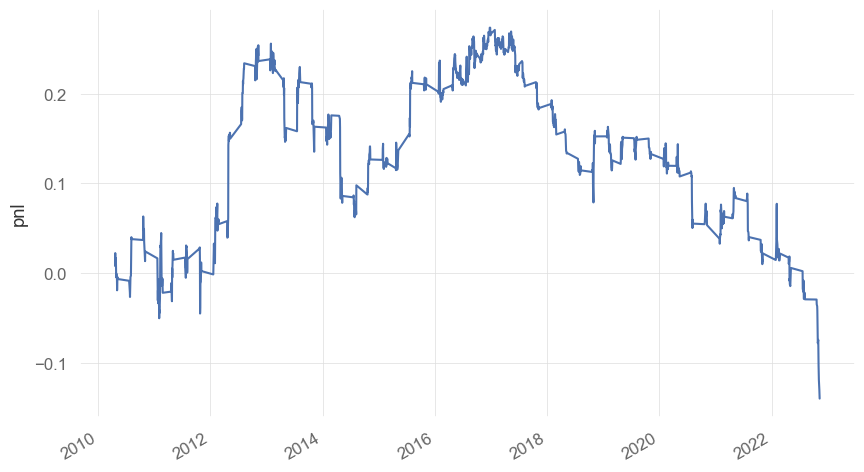

In [176]:
SIGNAL = signal.reindex_like(P)[P]
SIGNAL = SIGNAL[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
# SIGNAL[SIGNAL.abs()<0.5] = None
SIGNAL = SIGNAL[P].sub(SIGNAL[P].mean(1),0)
# SIGNAL = SIGNAL[P].groupby(GICS['gicsect'],axis=1).apply(center)
SIGNAL = SIGNAL[P].div(SIGNAL.abs().sum(1),0)

pnl = (SIGNAL[P].shift()*R).dropna(0,'all').sum(1)
sr = sharpe(pnl)
turnover = SIGNAL.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)